# Tutorial: tutorial_global_oce_latlon

### Written by M. Wood. November 2021

This verification experiment is almost identical to the tutorial_global_oce_latlon experiment configured with the files in the `tutorial_global_oce_latlon/input` directory, except that it uses `diagnostics_vec` to output variables from the model and compares them to variables from the standard output to show that the two are identical.

The purpose of this experiment is show that a new update to the `diagnostics_vec` package works as desired: the ability to cap the number of iterations stored in each diagnostics_vec ouput file.

This tutorial follows 5 steps:
1. Prepare the configuration
2. Prepare the diagnostic_vec masks
3. Build the model
4. Run the model
5. Compare diagnostics_vec vs standard output


### 1. Prepare the configuration
To prepare the configuration, `cd` to the `input_dv` directory within the `global_with_exf`  experiment. As for the code in the base experiment `input` directory, we provide a **prepare_run** script which can be used to generate all of the necessary files (aside from the few already provided). Run this from the command line, e.g.:

### 2. Prepare the diagnostics_vec masks

The diagnostics_vec masks are generated using a simple Python script, `create_masks.py`, which is additionally provided in the input_dv directory. Create the masks (from within the input_dv directory) by running the script:

This script creates five masks - four which laterally bound a subdomain in the pacific ocean, and one which covers the entire surface of the subdomain. To view these masks relative to the model bathymetry, we can read and plot them as follows:

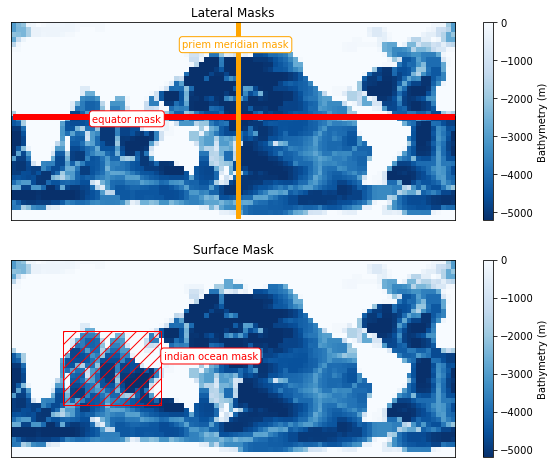

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# set the path to the input directory (UPDATE FOR YOUR SYSTEM)
input_dir = '/Users/michwood/Documents/Research/Projects/Ocean_Modeling/'\
            'Projects/Diagnostics_vec_development/MITgcm/verification/'\
            'tutorial_global_oce_latlon/input_dv'

Nx = 90
Ny = 40

lateral_mask_names = ['equator_mask','prime_meridian_mask']

# collect the mask files
lateral_mask_grids = []
for mask_name in lateral_mask_names:
    mask_file = os.path.join(input_dir,mask_name+'.bin')
    mask_grid = np.fromfile(mask_file,dtype='>f4')
    mask_grid = np.reshape(mask_grid,(Ny,Nx))
    lateral_mask_grids.append(mask_grid)
surface_mask_file = os.path.join(input_dir,'indian_ocean_mask.bin')
surface_mask_grid = np.fromfile(surface_mask_file,dtype='>f4')
surface_mask_grid = np.reshape(surface_mask_grid,(Ny,Nx))

# read the bathymetry
bathy_file = os.path.join(input_dir,'bathymetry.bin')
bathy_grid = np.fromfile(bathy_file,dtype='>f4')
bathy_grid = np.reshape(bathy_grid,(Ny,Nx))

# plot the masks on the bathymetry
fig = plt.figure(figsize=(10,8))
mask_plot_colors = ['red','orange','green','purple']

plt.subplot(2,1,1)
plt.title('Lateral Masks')
C = plt.imshow(bathy_grid,origin='lower',cmap='Blues_r')
cbar = plt.colorbar(C)
cbar.set_label('Bathymetry (m)')
for mn in range(len(lateral_mask_grids)):
    rows,cols = np.where(lateral_mask_grids[mn]!=0)
    for pt in range(len(rows)):
        rect = Rectangle((cols[pt],rows[pt]),1,1,color=mask_plot_colors[mn])
        plt.gca().add_patch(rect)
plt.text(23,20,'equator mask',color=mask_plot_colors[0],ha='center',va='center',
         bbox=dict(boxstyle="round",ec=mask_plot_colors[0],fc='w'))
plt.text(45,35,'priem meridian mask',color=mask_plot_colors[1],ha='center',va='center',
         bbox=dict(boxstyle="round",ec=mask_plot_colors[1],fc='w'))

plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.subplot(2,1,2)
plt.title('Surface Mask')
C = plt.imshow(bathy_grid,origin='lower',cmap='Blues_r')
cbar = plt.colorbar(C)
cbar.set_label('Bathymetry (m)')
rows,cols = np.where(surface_mask_grid!=0)
rect = Rectangle((np.min(cols),np.min(rows)),
                 np.max(cols)-np.min(cols),np.max(rows)-np.min(rows),
                 color='red',hatch='//',fill=False)
plt.gca().add_patch(rect)
plt.text(40,20,'indian ocean mask',color='red',ha='center',va='center',
         bbox=dict(boxstyle="round",ec='red',fc='w'))

plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.show()

### 3. Build the model
For this experiement, we provide options for configuring the model with and without MPI. Build the model according to your system specifications. For example:

### 4. Run the model
With the model built, run it as you would on your system.

### 5. Compare Diagnostics_vec vs Standard Model Output

In [47]:
# set the path to the run directory (UPDATE FOR YOUR SYSTEM)
run_dir = '/Users/michwood/Documents/Research/Projects/Ocean_Modeling/'\
            'Projects/Diagnostics_vec_development/MITgcm/verification/'\
            'tutorial_global_oce_latlon/run'

Nx = 90
Ny = 40
nTimesteps = 20
Nr = 15

equator_row = 20
primt_meridian_col = 45

# extents of the surface mask (defined in input_dv/create_masks.py)
min_row = 10
max_row = 25
min_col = 10
max_col = 30

#### Compare the lateral boundaries 
First, we can compare the model output via diagnostics_vec with the standard model output on the equator or prime meridian masks we defined:

(5, 15, 90) (20, 15, 90)
15 90 40 0 5
(5, 15, 90) (20, 15, 90)
15 90 40 1 5
(5, 15, 90) (20, 15, 90)
15 90 40 2 5
(5, 15, 90) (20, 15, 90)
15 90 40 3 5


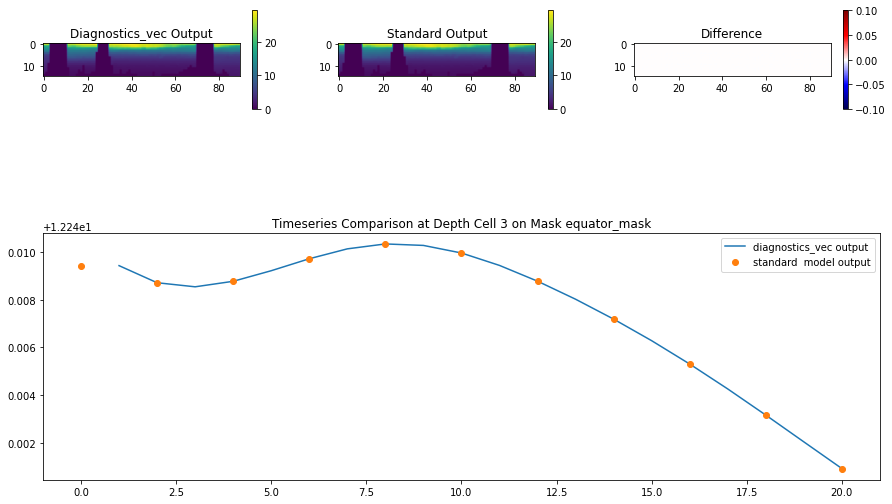

In [54]:
from MITgcmutils.mds import rdmds

# choose some parameters to plot 
var_name = 'THETA' # THETA or SALT
mask_name = 'equator_mask' # equator or prime_meridian
diag_vec_timestep = 11 # 1 - 20
diag_timestep = 6 # 0 20
test_row = 5 # between 0 and 40 for equator mask
test_col = 15 # between 0 and 90 for prime meridian mask
test_depth_level = 3

# the number of iters in each mask
if mask_name == 'equator_mask':
    iters_per_file = 5
if mask_name == 'prime_meridian_mask':
    iters_per_file = 4

# fill in a matrix with the diagnostics_vec output
if mask_name == 'equator_mask':
    diag_vec_output = np.zeros((nTimesteps,Nr,Nx))
if mask_name == 'prime_meridian_mask':
    diag_vec_output = np.zeros((nTimesteps,Nr,Ny))
for i in range(int(nTimesteps/iters_per_file)):
    file_path = os.path.join(run_dir,
                             mask_name+'_'+var_name+'.'+'{:010d}'.format(i*iters_per_file+1)+'.bin')
    diag_vec_output_subset = np.fromfile(file_path,'>f4')
    if mask_name == 'equator_mask':
        diag_vec_output_subset = np.reshape(diag_vec_output_subset,(iters_per_file,Nr,Nx))
    if mask_name == 'prime_meridian_mask':
        diag_vec_output_subset = np.reshape(diag_vec_output_subset,(iters_per_file,Nr,Ny))
    diag_vec_output[i*iters_per_file:(i+1)*iters_per_file,:,:] = diag_vec_output_subset
    
diag_vec_timeseries = diag_vec_output[:,test_depth_level,test_col]
diag_vec_comparison_field = diag_vec_output[diag_vec_timestep,:,:]


# read in the diagnostics output
file_prefix = os.path.join(run_dir,var_name[0])
standard_output = rdmds(file_prefix,[0,2,4,6,8,10,12,14,16,18,20])

if mask_name=='equator_mask':
    standard_output_comparison_field = standard_output[diag_timestep,:,
                                                      equator_row,:]
    standard_output_timeseries = standard_output[:,test_depth_level,equator_row,test_col]
if mask_name =='prime_meridian_mask':
    standard_output_comparison_field = standard_output[diag_timestep,:,
                                                      :,prime_meridian_col]
    standard_output_timeseries = standard_output[:,test_depth_level,test_row,prime_meridian_col]
    
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
C = plt.imshow(diag_vec_comparison_field)
plt.colorbar(C, shrink=0.4)
plt.title('Diagnostics_vec Output')

plt.subplot(2,3,2)
C2 = plt.imshow(standard_output_comparison_field)
plt.colorbar(C2, shrink=0.4)
plt.title('Standard Output')

plt.subplot(2,3,3)
C3 = plt.imshow(diag_vec_comparison_field - standard_output_comparison_field,cmap='seismic')
plt.colorbar(C3, shrink=0.4)
plt.title('Difference')

plt.subplot(2,1,2)
plt.plot(np.arange(1,21),diag_vec_timeseries,label='diagnostics_vec output')
plt.plot(np.array([0,2,4,6,8,10,12,14,16,18,20]),standard_output_timeseries,'.',markersize=12,
         label='standard  model output')
plt.legend()
plt.title('Timeseries Comparison at Depth Cell '+str(test_depth_level)+' on Mask '+mask_name)
plt.show()


#### Compare the surface (exf) variables
Next, we can compare the external forcing fields as output from diagnostics_vec and diagnostics:

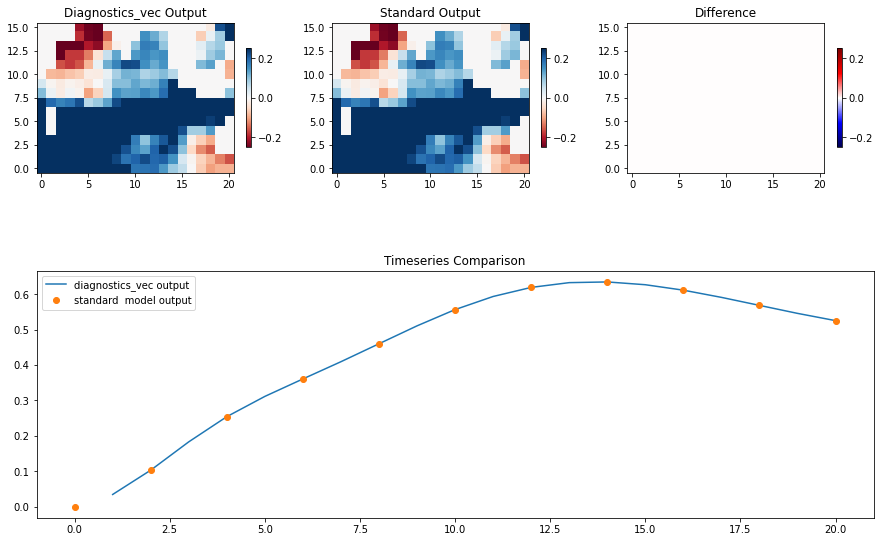

In [56]:
from MITgcmutils.mds import rdmds

# choose some parameters to plot 
var_name = 'ETAN'
diag_vec_timestep = 11 #360, 1080, or 1800
diag_timestep = 6
test_row = 5 # between 0 and 20 (=max_row - min_row)
test_col = 5 # between 0 and 40 (=max_col - min_col)
iters_per_file = 10

# fill in a matrix with the diagnostics_vec output
diag_vec_output = np.zeros((nTimesteps,max_row-min_row+1,max_col-min_col+1))
for i in range(int(nTimesteps/iters_per_file)):
    file_path = os.path.join(run_dir,
                             'indian_ocean_mask_'+var_name+'.'+'{:010d}'.format(i*iters_per_file+1)+'.bin')
    diag_vec_output_subset = np.fromfile(file_path,'>f4')
    diag_vec_output_subset = np.reshape(diag_vec_output_subset,(iters_per_file,max_row-min_row+1,max_col-min_col+1))
    diag_vec_output[i*iters_per_file:(i+1)*iters_per_file,:,:] = diag_vec_output_subset
    
diag_vec_timeseries = diag_vec_output[:,test_row,test_col]
diag_vec_comparison_field = diag_vec_output[diag_vec_timestep,:,:] #no IC's here

# # read in the diagnostics output
file_prefix = os.path.join(run_dir,'Eta')
standard_output = rdmds(file_prefix,np.arange(0,21,2).tolist())
standard_output_comparison_field = standard_output[diag_timestep,
                                                   min_row:max_row+1,min_col:max_col+1]
standard_output_timeseries = standard_output[:,min_row+test_row,min_col+test_col]

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
C = plt.imshow(diag_vec_comparison_field,origin='lower',cmap='RdBu',vmin=-0.25,vmax=0.25)
plt.colorbar(C, shrink=0.4)
plt.title('Diagnostics_vec Output')

plt.subplot(2,3,2)
C2 = plt.imshow(standard_output_comparison_field,origin='lower',cmap='RdBu',vmin=-0.25,vmax=0.25)
plt.colorbar(C2, shrink=0.4)
plt.title('Standard Output')

plt.subplot(2,3,3)
C3 = plt.imshow(diag_vec_comparison_field - standard_output_comparison_field,origin='lower',
                cmap='seismic',vmin=-0.25,vmax=0.25)
plt.colorbar(C3, shrink=0.4)
plt.title('Difference')

plt.subplot(2,1,2)
plt.plot(np.arange(1,21),diag_vec_timeseries,label='diagnostics_vec output')
plt.plot(np.arange(0,21,2),standard_output_timeseries,'.',markersize=12,
         label='standard  model output')
plt.legend()
plt.title('Timeseries Comparison')
plt.show()
